<a href="https://colab.research.google.com/github/acse-xm421/ACSE-19-20/blob/master/acse-xm421_coursework_I.ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://drive.google.com/uc?id=1dFgNX9iQUfmBOdmUN2-H8rPxL3SLXmxn" width="400"/>


---


### ***Name***: Mi, Xuefei
### ***CID***: 02084183

# Instructions:

Follow the instructions below to complete the coursework and submit it:

<br>

1. Complete your coursework using this provided Jupyter Notebook template (use Google Colab or your local machine if it has a GPU and/or sufficient computational power). Your copy of the notebook should be named: `yourusername_coursework_I.ipynb`. And don't forget to fill in the two fields at the top of this notebook with your name and CID.

<br>

2. Once you have completed your answers, upload your final notebook to the repo you got from the github classroom link. Make sure to have all the answers in there:

   - **All the cells in your final Jupyter Notebook should be executed before saving and uploading to github in order to have the output of the cells available in the uploaded version** (images you plot, training graphs generated with `livelossplot`, etc). We will not rerun code blocks in the notebooks, it is your responsibility to run them before uploading the notebook.

   - Add comments in the code to explain what you are doing at every step. 

   - All answers requiring written answers (ie, not code) should be in markdown blocks in the Jupyter Notebook. This provided Jupyter Notebook template has allocated blocks for the questions, but **you can add any coding or markdown blocks you need**.

<br>

3. The coursework is released on **Friday 9 December at 14:00h UK time**, and the answers have to be submitted on **Monday 12 December, 20:00h UK time**. We will not accept late submissions.

<br>

<br>

### The coursework consists of 5 questions you have to complete. You will find them below. 

- Questions 2 and 3 are very similar and you have to complete both of them, **you DO NOT have to choose one of them, you have to do them both.**

- <mark style=background-color:yellow>You can use code seen in class, but indicate clearly when you do, and **make it clear (using comments or markdown blocks) what are your modifications**. This will influence your final marks.<MARK>

- Your final marks will depend both on the quality of your results **AND** the justification, explanation and rationale of your implementations.

- Reference any publications and other materials that you use, but keep in mind that **your implementations should be original and not copied from any online resources (we will check for plagiarism)**. It is ok to use other resources to understand concepts and draw inspiration, but always <mark style=background-color:yellow>reference them properly in the notebook.<mark>

- Finally, **justify your answers well, but focus on what the question is asking**. I will penalise lengthy answers that do not have any relation with the question being addressed.

<br>

---

<br>

## Imports

In [ ]:
!pip install pycm livelossplot
%pylab inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.8/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['Generator', 'seed', 'Normalize', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [ ]:
import random
import time
import math

import glob
import string
import unicodedata
import re
from collections import Counter
from tqdm import tqdm

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torchsummary import summary
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from livelossplot import PlotLosses

import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from pycm import *

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  # uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    print(torch.cuda.get_device_name())
    device = 'cuda'
else:
    print("No GPU available! Running on CPU")

Cuda installed! Running on GPU!
Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


<br>

---

<br>

## **Q1** - Download and prepare the Fashion MNIST dataset [10 points]

Get the `FashionMNIST` dataset from `torchvision.datasets`

- Inspect the dataset and format the data as you see fit to use it in your next questions. Explain the process you follow.

- Plot a matrix of images with 10 examples of each class.

- Is the dataset well balanced (does it have similar number of samples for each class)? Generate and present data to support your answer in any form you see fit.

First, download the dataset.

The models are VAE and GAN, so no need for test dataset.

In [ ]:
mnist_train = FashionMNIST("./", download=True, train=True)
mnist_test = FashionMNIST("./", download=True, train=False)

have a look at the dataset first.

In [ ]:
mnist_train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train

In [ ]:
mnist_train.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [ ]:
print(mnist_train.class_to_idx)

{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


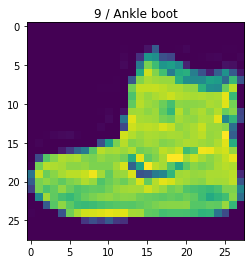

In [ ]:
class_to_idx = list(mnist_train.class_to_idx)
plt.imshow(mnist_train[0][0])
plt.title(str(mnist_train[0][1]) + " / " + class_to_idx[mnist_train[0][1]])
plt.show()



Add transformation to the dataset. At first, all we need is the simple transformation of the dataset to torch. Tensor objects to allow PyTorch handling, and the standardisation of the data.

In [ ]:
# split the data
# shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(mnist_train.train_data, mnist_train.train_labels) 
# indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

# mnist_train.train_data[indices[0]]

In [ ]:
from torchvision.transforms import Compose, ToTensor, Normalize

transform = Compose([ToTensor(),
                     Normalize(mean=[.5], std=[.5]), # Normalize(mean=[0.2860405743122101], std=[0.3530242443084717])
                     ]) 

train_dataset = FashionMNIST(root="./", train=True, download=False, transform=transform, target_transform=None)
test_dataset = FashionMNIST(root="./", train=False, download=False, transform=transform, target_transform=None)

print(train_dataset)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )


The process of training in Pytorch relies on batch management of a particular dataset. This is done using the Dataloader module, which is responsible for accessing a Dataset derived object and handling it according to our needs.

In [ ]:
batch_size=64
test_batch_size=1000

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)

Plot a matrix of images with 10 examples of each class.

torch.Size([100, 1, 28, 28])


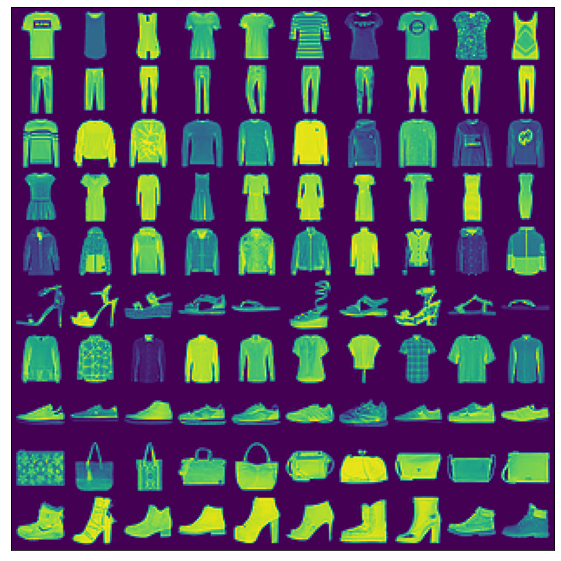

In [ ]:
classDict={}
pics = torch.empty(0)
for i in range(10):
    mask = (mnist_train.targets == i)
    classDict[i] = mnist_train.data[mask][:10]
    classDict[i] = classDict[i][:, None,: ,: ] # add the channel column
    pics = torch.cat((pics,classDict[i]))
    # print(classDict[i].shape)

print(pics.shape)

from torchvision.utils import make_grid
batch_grid = make_grid(pics, nrow=10, padding=3)
plt.figure(figsize=(10,10))
plt.imshow(batch_grid[0]) # index because make_grid transforms grayscale images to RGB? If it only contains one color, it will generate three same color columns, just randomsly choose a index.
plt.xticks([])
plt.yticks([])
plt.show()


Is the dataset well balanced (does it have similar number of samples for each class)? Generate and present data to support your answer in any form you see fit.

The dataset is well balanced, as shown in the plot below. And the classNum can also demonstrate that it is perfectly balanced. 

[6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]


Text(0.5, 1.0, 'the number of different classes')

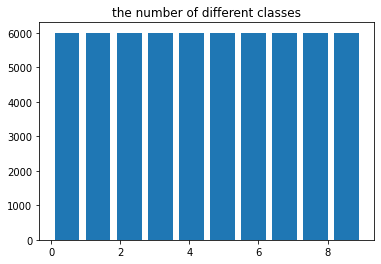

In [ ]:
classNum=[]
for i in range(10):
    mask = (mnist_train.targets == i)
    classNum.append(mask.sum().item())

print(classNum)
plt.hist(mnist_train.targets, rwidth=0.8)
plt.title('the number of different classes')

<br>

---

<br>

## **Q2** - Implement a **conditional VAE** [25 points]

Implement a VAE similar to the one we saw in class but with the following modifications:

- Your new network should generate samples of any class defined by the user, that is, when you run your decoder, you have to tell it which class you want it to generate. <br> *During the lectures we created a VAE that would generate samples of any class, we did not have control over which class would be generated. The exercise is to modify the network, training loops, and anything else you consider necessary, so that, once is trained, you can generate images of any particular class specified when you run your generative model.*

- Expand your network to include **at least two** of the following modifications. Choose them based on what you think will result in better network performance (make sure to justify your choices well, argumenting why did you decide to include your particular modifications):
  - Convolutional layers
  - Data augmentation 
  - Different activations
  - Different random seed
  - Other network modifications that are well justified. <br> *You have freedom to choose what to do here, but your marks will depend not only on the correct implementation but also on the justification of your choices.*

- Use your trained conditional VAE to **generate and plot 10 new samples of each class** by adding the class label to your random input (in any form you have implemented it).

- You **DO NOT** have to optimise any hyperparameters, but if you had to choose three hyperparameters to optimise:
  - Which ones would you choose and <mark style=background-color:yellow>why<mark>?GRID SEARCH?

Generate information of your training process (liveloss plots, or any other data that will help you understand your results and analyse them in the last question **Q4**).



CVAE with no modifications:

In [ ]:
class CVAE_Encoder(nn.Module):
  def __init__(self):
    '''
    Class contains the Encoder (image -> latent).
    '''
    super(CVAE_Encoder, self).__init__()

    self.layer1 = nn.Sequential(
        nn.Linear(794, 512), # add one input feature to accommodate label value
        nn.ReLU()
    )

    self.layer2 = nn.Sequential(
        nn.Linear(512, 256),
        nn.ReLU()
    )

    self.layer3 = nn.Sequential(
        nn.Linear(256, 128),
        nn.ReLU()
    )

    self.layerMu = nn.Sequential(
        nn.Linear(128, 16),
    )

    self.layerSigma = nn.Sequential(
        nn.Linear(128, 16),
    )

  def forward(self, x, l):
    '''
    x: [float] the MNIST image
    l: [int] labels for generative images
    '''
    # create conditional input by concatnating flattened image and label
    x = torch.flatten(x, start_dim = 1)
    x = torch.cat((x, l), dim=1)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    mu =  self.layerMu(x)
    sigma = torch.exp(self.layerSigma(x))
    return mu, sigma


class CVAE_Decoder(nn.Module):
  def __init__(self):
    '''
    Class contains the Decoder (latent -> image).
    '''

    super(CVAE_Decoder, self).__init__()

    self.layerLatent = nn.Sequential(
        nn.Linear(26, 128), # add one input feature to accommodate label value
    )

    self.layer1 = nn.Sequential(
        nn.Linear(128, 256),
        nn.ReLU()
    )

    self.layer2 = nn.Sequential(
        nn.Linear(256, 512),
        nn.ReLU()
    )

    self.layer3 = nn.Sequential(
        nn.Linear(512, 784),
        nn.Sigmoid()
    )

  def forward(self, z, l):
    '''
    z: [float] points in the latent space 
    l: [int] labels for generative images
    '''
    # create conditional input by concatnating point z in the latent space and label
    print('z.shape',z.shape)
    print('l.shape',l.shape)

    z = torch.cat((z, l),dim=1)
    print('z.shape',z.shape)


    z = self.layerLatent(z)
    z = self.layer1(z)
    z = self.layer2(z)
    z = self.layer3(z)
    return z.reshape((-1,1,28,28))



In [ ]:
class CVAE(nn.Module):
  def __init__(self, device):
    '''
    Class combines the Encoder and the Decoder with a CVAE latent space.
    '''
    super(CVAE, self).__init__()
    self.device = device
    self.encoder = CVAE_Encoder()
    self.decoder = CVAE_Decoder()
    self.distribution = torch.distributions.Normal(0, 1)

  def sample_latent_space(self, mu, sigma):
    z = mu + sigma * self.distribution.sample(mu.shape).to(self.device)
    kl_div = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
    return z, kl_div

  def forward(self, x, l):
    '''
    x - [float] A batch of images from the data-loader
    l: [int] labels for generative images
    '''
    
    mu, sigma = self.encoder(x, l)
    z, kl_div = self.sample_latent_space(mu, sigma)
    z = self.decoder(z, l)
    return z, kl_div


In [ ]:
# simple CVAE hyperparameters
epochs=10
dims_latent = 16 # Maybe increase this an try the t-sne algorithm for visualisation?!

# Adam
lr=0.001
weight_decay=0

In [ ]:
def train_cvae(epochs, train_loader):
  model = CVAE(device).to(device)
  model.train()

  opt = torch.optim.Adam(model.parameters(), lr=lr)
  # opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  
  liveloss = PlotLosses()
  for epoch in range(epochs):
      logs = {}
      train_loss = 0
      for batch, label in tqdm(train_loader):
        label = F.one_hot(label, 10)
        # print('label',label)
        batch, label = batch.to(device), label.to(device)
        opt.zero_grad()
        x_hat, KL = model(batch, label)
        loss1 = ((batch - x_hat)**2).sum()

        # print('((batch - x_hat)**2).sum()=', loss1)
        # print('KL=', KL)
        
        loss = loss1 + KL  # Calculate combined loss
        loss.backward()
        train_loss += loss*batch.size(0)
        opt.step()
      train_loss = train_loss/len(train_loader.dataset)
      
      logs['' + 'log loss'] = train_loss.item()

      liveloss.update(logs)
      liveloss.draw()
      
  return model


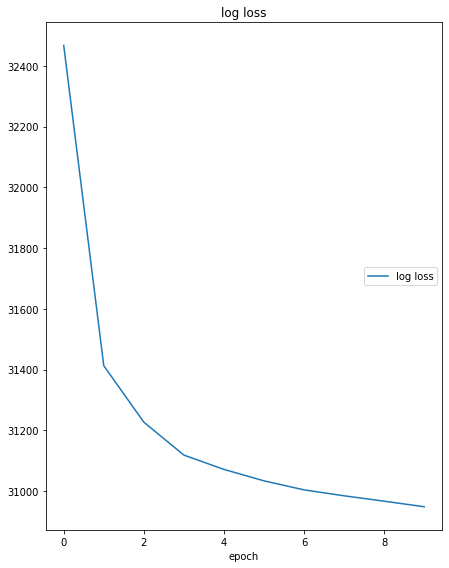

log loss
	log loss         	 (min: 30948.707, max: 32467.361, cur: 30948.707)


In [ ]:
cvae = train_cvae(epochs=epochs, train_loader=train_loader)

In [ ]:
# save the model
torch.save(cvae.state_dict(), "./CVAE.pth")

torch.Size([1000, 1, 28, 28])
torch.Size([1, 10])
torch.Size([1, 1, 28, 28])
torch.Size([1, 10])
torch.Size([1, 1, 28, 28])
torch.Size([1, 10])
torch.Size([1, 1, 28, 28])
torch.Size([1, 10])
torch.Size([1, 1, 28, 28])
torch.Size([1, 10])
torch.Size([1, 1, 28, 28])


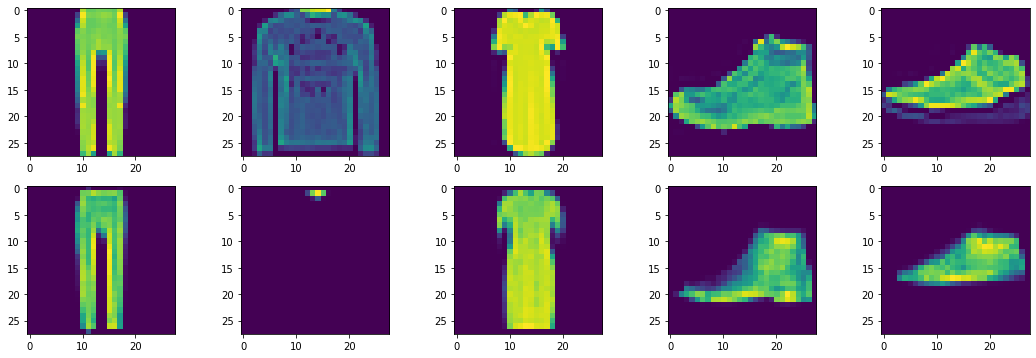

In [ ]:
images, labels = next(iter(test_loader))  # Get the first batch of images
print(images.shape)  # Get the first image from the batch

_, ax = plt.subplots(2, 5, figsize=[18.5, 6])
for n, idx  in enumerate(torch.randint(0,images.shape[0], (5,))):
  print(F.one_hot(labels[idx],10)[None,:].shape)
  print(images[idx].unsqueeze(0).shape)
  recon, _ = cvae(images[idx].unsqueeze(0).cuda(), F.one_hot(labels[idx],10)[None,:].to(device))  # Are mu and sigma correct
  ax[0, n].imshow(images[idx].squeeze())
  ax[1, n].imshow(recon.cpu().detach().squeeze())


In [ ]:
def plot_sample(autoencoder, z, l):
    # print(l.shape)
    img = autoencoder.decoder(z, l)#.to('cpu').detach().numpy()#[0,0]
    batch_grid_2 = make_grid(img, nrow=10, padding=3)
    plt.figure(figsize=(15,15))
    plt.imshow(batch_grid_2[0].to('cpu').detach().numpy()) # index because make_grid transforms grayscale images to RGB? If it only contains one color, it will generate three same color columns, just randomsly choose a index.
    plt.xticks([])
    plt.yticks(np.arange(15, 300, 30), ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], rotation=45, fontsize=20)
    plt.show()
    plt.savefig("./generated_image.jpg")  # Save the figure to google drive!
    # print(z)



In [ ]:
# l = torch.empty(0)
# for i in np.arange(10):
#   l = torch.cat((l,torch.ones(10, dtype = torch.long) * i))
# l = l.type(torch.LongTensor).to(device)
# print(l)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9], device='cuda:0')


In [ ]:
z = torch.randn((100,16)).to(device).float()
l = torch.empty(0)
for i in np.arange(10):
  l = torch.cat((l,torch.ones(10, dtype = torch.long) * i))
l = l.type(torch.LongTensor)
l = F.one_hot(l)
l = l.to(device)
print(l.shape)
print(l)

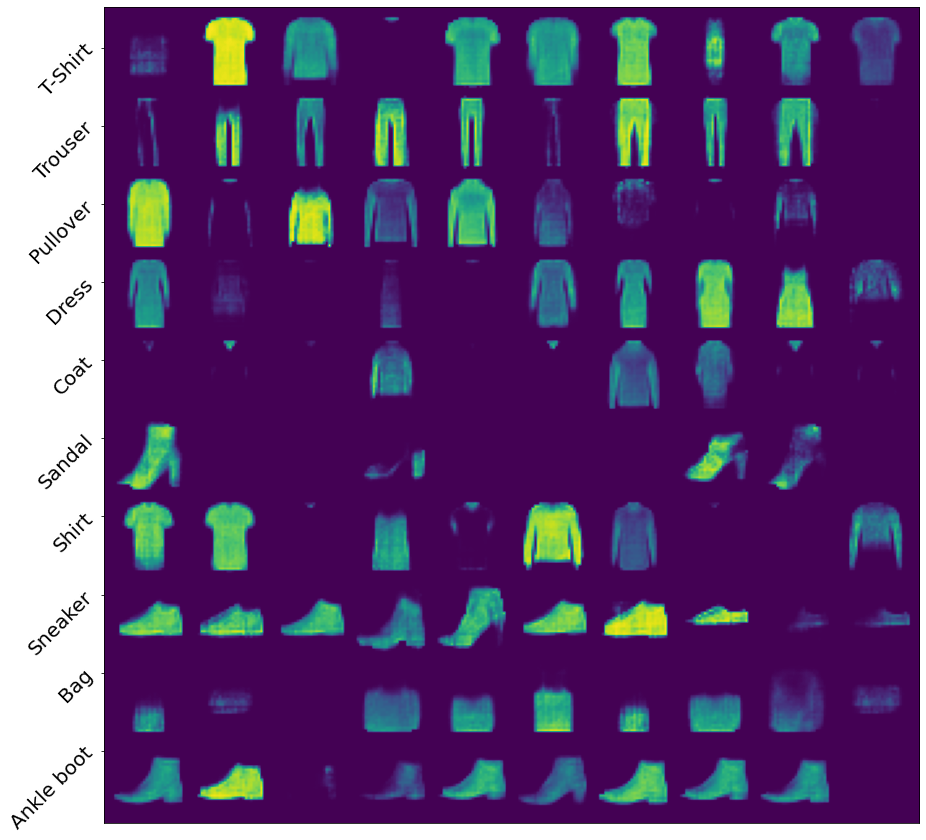

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_sample(cvae, z, l)

### Hyperparameters:

I will choose to modify epochs, learning rate, and the dimension of latent space.

As seen from the generative new pictures, my model is in the state of underfitting. There are many blanks and wrongly generated picture of certain label, which means it hasn't successfully extracted all features of this dataset. So, I need to increase the number of epochs (like from 10 to 30), reduce learning rate(from 0.001 to 0.0001), and increase the dimension of latent space (from 16 to 32).

### CVAE with modifications:

- Use Convolutional layers to replace linear layers, because linear layers are too simple to extract features in the picture. They will lose inportant spatial information (relative positions between pixels) once the image is flattened, but convolutional layers won't, so they are more suitable for images.

- Add BatchNorm2d layer. Before using BatchNorm layer, I found my model's loss oscillates badly. The model seems unable to find a correct direction to reduce the loss and it runs slowly, sometimes even have Inf and Nan losses. Considering BatchNorm can act as a regulariser that smooths the objective function (and therefore make it better suited to gradient descent minimisation methods), reduce the probability that vanishing or exploding gradients occur, accelerates training by stabilizing the layer changes through the iterations, and also provide some regularization, like dropout, but not as strong, therefore, I used BatchNorm in my model, and the loss plot and generative picture became better.

- Change avtivation layer from ReLU to GeLU, because the derivative of ReLU is not consistent at 0, which may cause problems when do back-propagation. The derivative of GeLU is always consistent.

- Set random seed as 0, because if not, the output will be much less reproducible. And I have tried other number such as 42, but 0 is more suitable for my model.

- Use data augmentation. Data augmentaion can increase our dataset by generating new samples based on the original dataset without changing the ideal response of the network to them.

#### Data Augmentation

In [ ]:
from torch.utils.data import Dataset 
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage

class CustomImageTensorDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        sample = sample.view(1, 28, 28).float()/255.
        if self.transform:
            sample = self.transform(sample)

        return sample, label



train_transform = Compose([
    ToPILImage(),
    RandomRotation(90),
    ToTensor(),
    Normalize(mean=[.5], std=[.5]), 
])

validation_test_transform = Compose([
    Normalize(mean=[.5], std=[.5])
])


train_dataset_1 = CustomImageTensorDataset(mnist_train.data, mnist_train.targets, transform=train_transform)     # create train custom dataset
test_dataset_1 = CustomImageTensorDataset(mnist_test.data, mnist_test.targets, transform=validation_test_transform) # create validation custom dataset
print(train_dataset_1)

train_loader_1 = DataLoader(train_dataset_1, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader_1 = DataLoader(test_dataset_1, batch_size=test_batch_size, shuffle=False, num_workers=0)
batch, label = next(iter(train_loader_1))
print(batch.shape)


# import cv2

# batch, _ = next(iter(train_loader))
# image = batch[0]
# _, ax = plt.subplots(1, 2, figsize=[10, 20])
# ax[0].imshow(image.squeeze(), 'gray')

# # convert the image to grayscale format
# image = image.cpu().detach().numpy()
# print('image.max:',image.max())
# print('image.min:',image.min())
# print('image.mean:',image.mean())
# # img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# ret, thresh = cv2.threshold(image, 0, 1, cv2.THRESH_BINARY)
# ax[1].imshow(thresh.squeeze())

torch.Size([64, 1, 28, 28])


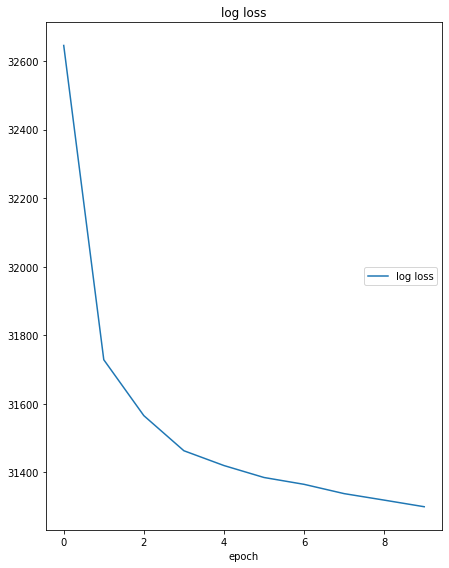

log loss
	log loss         	 (min: 31300.129, max: 32645.242, cur: 31300.129)


In [ ]:
cvae_1 = train_cvae(epochs=epochs, train_loader=train_loader_1)


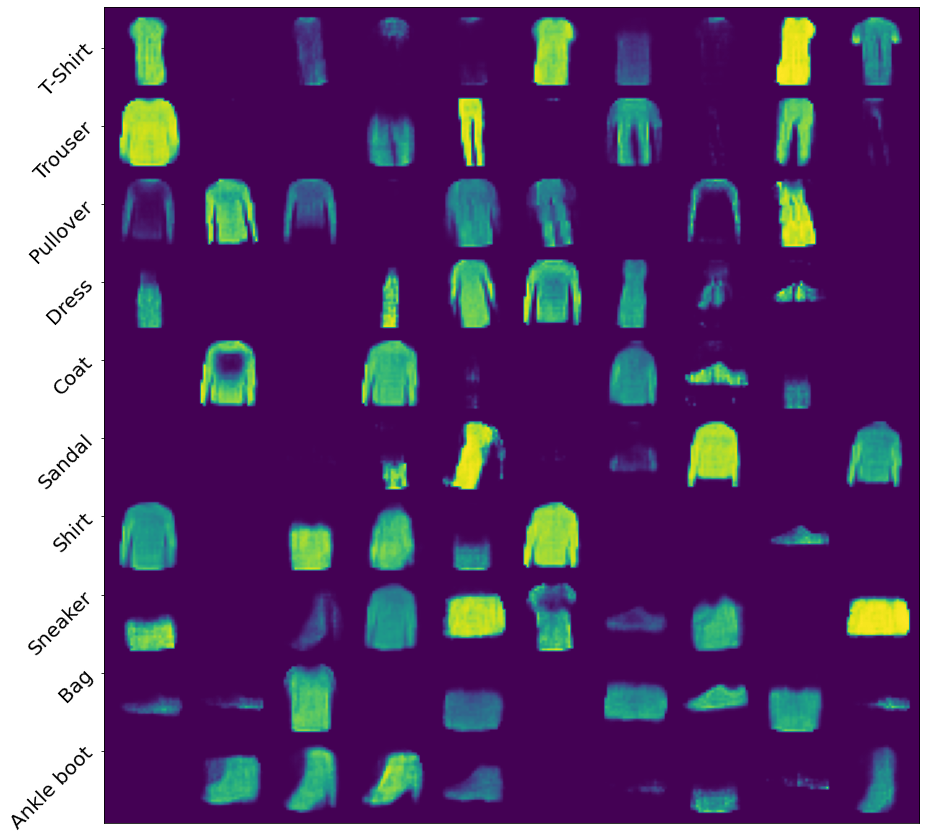

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_sample(cvae_1, z, l)

#### **CVAE** with convolutional layer:

In [ ]:
# Convolutinal CVAE hyperparameters
seed=0
set_seed(seed)
epochs=10


# Adam
weight_decay=0
lr=0.01

In [ ]:
class VAE_Encoder(nn.Module):  # The Encoder inherits the properties of nn.Module https://pytorch.org/docs/stable/generated/torch.nn.Module.html
  def __init__(self):
    '''
    Class contains the Encoder (image -> latent).
    '''
    super(VAE_Encoder, self).__init__()

    self.cnn1 = nn.Conv2d(1,4,3)
    self.cnn2 = nn.Conv2d(4,8,3)


    self.layer0 = nn.Linear(784, 512)
    self.transform0 = nn.ReLU()
    self.layer1 = nn.Linear(512, 256)
    self.transform1 = nn.ReLU()

  def forward(self, x, l):  # Custom pytorch modules should follow this structure 
    '''
    x: [float] the MNIST image
    '''
    x = self.c1(x)
    x = self.c2(x)

    x = torch.flatten(x, start_dim = 1)  # Reshape the input into a vector (nD to 1D) 
    x = torch.cat((x, l), dim=1)
    x = self.transform0(self.layer0(x))  # Run Image through Linear transform then ReLu activation function
    x = self.transform1(self.layer1(x))  # Run Image through Linear transform then ReLu activation function
    return x


class VAE_Decoder(nn.Module):
  def __init__(self):
    '''
    Class contains the Decoder (latent -> image).
    '''

    super(VAE_Decoder, self).__init__()
    self.layer1 = nn.Linear(256, 512)  # Connectivity Latent to Hidden
    self.activation1 = nn.ReLU()
    self.layerOut = nn.Linear(512, 784)  # Connectivity Hidden to Image
    self.activationOut = nn.Sigmoid()

  def forward(self, z):
    '''
    z: [float] a sample from the latent variable
    '''

    z = self.activation1(self.layer1(z))  # Run Image through Linear transform then ReLu activation function
    z = self.activationOut(self.layerOut(z))  # Run Image through Linear transform then Sigmoid activation function
    return  z.reshape((-1,1,28,28))  # Reshape the vector into an image


class VariationalAutoencoder(nn.Module):
  def __init__(self, dims_latent):
    '''
    Class combines the Encoder and the Decoder.

    dims_latent: [int] the dimension of (number of nodes in) the mean-field gaussian latent variable
    '''
    
    super(VariationalAutoencoder, self).__init__()
    self.encoder = VAE_Encoder()
    self.decoder = VAE_Decoder()

    self.layerMu = nn.Linear(256, dims_latent)  # Hidden to latent, fully connected
    self.layerSig = nn.Linear(256, dims_latent)  # Hidden to latent, fully connected
    self.distribution = torch.distributions.Normal(0, 1)  # Sample from N(0,1)

    self.latentOut = nn.Linear(dims_latent, 256)  # Connectivity Latent to Hidden
    self.activationOut = nn.ReLU()


  def vae_latent_space(self, x):
    mu =  self.layerMu(x)  # Turn the output of the Encoder into Mu
    sigma = torch.exp(self.layerSig(x))  # Exponential activation ensures positivity for Sigma
    z = mu + sigma * self.distribution.sample(mu.shape).to(device)
    kl_div = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
    return z, kl_div

  def forward(self, x, label):
    x = self.encoder(x, label)
    z, kl_div = self.vae_latent_space(x)
    z = self.activationOut(self.latentOut(z))  # Take the latent vector and make the input for the Decoder
    return self.decoder(z), kl_div

def train(autoencoder, data, kl_div_on=True, epochs=10):
  opt = torch.optim.Adam(autoencoder.parameters())
  for epoch in range(epochs):  # Run data over numerous epochs
    for batch, label in data:  # Iterate over the batches of images and labels
      batch = batch.to(device)  # Send batch of images to the GPU
      label = F.one_hot(label, 10).to(device)

      opt.zero_grad()  # Set optimiser grad to 0
      x_hat, KL = autoencoder(batch, label)  # Generate predicted images (x_hat) by running batch of images through autoencoder
      loss = ((batch - x_hat)**2).sum() + KL  # Calculate combined loss
      loss.backward()  # Back-propagate
      opt.step()  # Step the optimiser
  return autoencoder  # Return the trained autoencoder (for later analysis)


dims_latent = 2  # Maybe increase this an try the t-sne algorithm for visualisation?!
VAE = VariationalAutoencoder(dims_latent).to(device)
VAE = train(VAE, data, 10)


In [ ]:
# original one
class CVAE_Encoder_Conv(nn.Module):
  def __init__(self):
    '''
    Class contains the Encoder (image -> latent).
    '''
    super(CVAE_Encoder_Conv, self).__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(2, 20, 3, padding=3),  # change in_channels from 1 to 2 to address label input meantime
        nn.GELU(),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(20),
        # nn.Dropout2d(p=0.2)
    )  # Dims in 32x32 -> out 16x16

    self.layer2 = nn.Sequential(
        nn.Conv2d(20, 40, 3, padding="same"),
        nn.GELU(),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(40),
        # nn.Dropout2d()
    )  # Dims in 16x16 -> out 8x8

    self.layer3 = nn.Sequential(
        nn.Conv2d(40, 60, 3, padding="same"),
        nn.GELU(),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(60),
        # nn.Dropout2d()
    )  # Dims in 8x8 -> out 4x4

    self.layerMu = nn.Sequential(
        nn.Conv2d(60, 120, 1), #nn.Conv2d(40, 60, 1), #
        # nn.BatchNorm2d(120)
        # nn.Dropout2d()
    )  # Dims in 4x4 -> out 4x4

    self.layerSigma = nn.Sequential(
        nn.Conv2d(60, 120, 1), # nn.Conv2d(40, 60, 1),
        # nn.BatchNorm2d(120)
        # nn.Dropout2d()
    )  # Dims in 4x4 -> out 4x4

  def forward(self, x, l, print_shape=False): 
    '''
    x: [float] the MNIST image
    '''
    # create a label channel and cancat it with input for creating the conditional input
    label_fill = torch.empty(0)
    for i in np.arange(x.shape[0]):
      label_fill = torch.cat((label_fill, torch.full((1,1,x.shape[2],x.shape[3]),l[i].item())), dim=0)
    x = torch.cat((x, label_fill.to(device)), dim=1)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    mu =  self.layerMu(x)
    sigma = F.softplus(self.layerSigma(x)) # change from torch.exp to F.softmax, bacause log(sigma) exploded.
    return mu, sigma

class CVAE_Decoder_Conv(nn.Module):
  def __init__(self):
    '''
    Class contains the Decoder (latent -> image).
    '''

    super(CVAE_Decoder_Conv, self).__init__()

    self.layerLatent = nn.Sequential(
        nn.Conv2d(121, 60, 1), #nn.Conv2d(61, 40, 1),# change in_channels from 120 to 121 to address label input meantime
        nn.GELU(),
        nn.Upsample(scale_factor=2, mode='nearest'),
        # nn.BatchNorm2d(60), # here can't use batchnorm
        # nn.Dropout2d()
    )  # Dims in 4x4 -> out 8x8

    self.layer1 = nn.Sequential(
        nn.Conv2d(60, 40, 3, padding='same'), #nn.Conv2d(40, 20, 3, padding='same'),
        nn.GELU(),
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.BatchNorm2d(40),
        # nn.Dropout2d()
    )  # Dims in 8x8 -> out 16x16

    self.layer2 = nn.Sequential(
        nn.Conv2d(40, 20, 3, padding='same'),
        nn.GELU(),
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.BatchNorm2d(20),
        # nn.Dropout2d()
    )  # Dims in 16x16 -> out 32x32

    self.layer3 = nn.Sequential(
        nn.Conv2d(20, 1, 3, padding='same'),
        nn.GELU(),
        nn.Sigmoid()
    )  # Dims in 32x32 -> out 32x32

  def forward(self, z, l, print_shape=False):
    '''
    x: [float] the MNIST image
    '''
    # create a label channel and cancat it with input for creating the conditional input
    label_fill = torch.empty(0)
    for i in np.arange(z.shape[0]):
      label_fill = torch.cat((label_fill, torch.full((1,1,z.shape[2],z.shape[3]),l[i].item())), dim=0)
    z = torch.cat((z, label_fill.to(device)),dim=1)


    z = self.layerLatent(z)

    z = self.layer1(z)
    z = self.layer2(z)
    z = self.layer3(z)
    return z[:,:,2:-2,2:-2]


Image shape: torch.Size([1, 1, 28, 28])


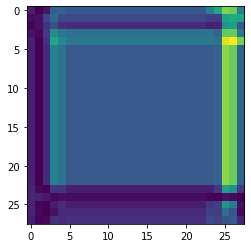

In [ ]:
decoder = CVAE_Decoder_Conv().to(device)

latent_vec = torch.zeros(1,120,4,4).to(device)

label = torch.ones(1)

recon = decoder(latent_vec, label, print_shape=True)

print('Image shape: '+str(recon.shape))

plt.imshow(recon.detach().cpu().squeeze())

In [ ]:
class CVAE_Conv(nn.Module):
  def __init__(self, device):
    '''
    Class combines the Encoder and the Decoder with a VAE latent space.
    '''
    super(CVAE_Conv, self).__init__()
    self.device = device
    self.encoder = CVAE_Encoder_Conv().to(self.device)
    self.decoder = CVAE_Decoder_Conv().to(self.device)
    self.distribution = torch.distributions.Normal(0, 1)

  def sample_latent_space(self, mu, sigma):
    z = mu + sigma * self.distribution.sample(mu.shape).to(self.device)
    # print('z=',z)
    kl_div = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum().to(self.device)
    # print('sigma**2 + mu**2 - torch.log(sigma)=',sigma**2 + mu**2 - torch.log(sigma))
    # print('kl_div=',kl_div)
    return z, kl_div

  def forward(self, x, l):
    '''
    x - [float] A batch of images from the data-loader
    '''

    mu, sigma = self.encoder(x,l)
    z, kl_div = self.sample_latent_space(mu, sigma)
    z = self.decoder(z,l)
    return z, kl_div


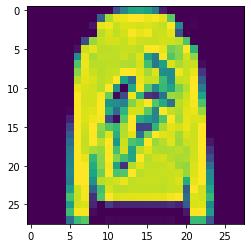

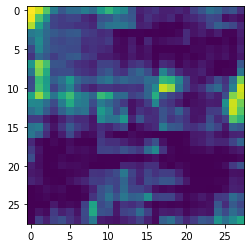

In [ ]:
cvae_conv = CVAE_Conv(device)

images, labels = next(iter(train_loader))
recon, _ = cvae_conv(images[10].unsqueeze(0).to(device), label[0][None])  # Are mu and sigma correct

plt.figure(); plt.imshow(images[0].squeeze())
plt.figure(); plt.imshow(recon.cpu().detach().squeeze())


In [ ]:
# lr = torch.optim.lr_scheduler.CosineAnnealingLR()
lr=1e-2
seed=0
set_seed(seed)

True

In [ ]:
liveloss = PlotLosses()

def train_cvae_conv(epochs):
  # set_seed(seed)

  model = CVAE_Conv(device).to(device).train(True)
  opt = torch.optim.Adam(model.parameters(), lr=lr)
  # opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

  
  for epoch in tqdm(range(epochs)):
      logs = {}
      train_loss = 0
      for batch, label in (train_loader):
        batch = batch.to(device) #label[:,None].to(device)
        # print(batch)
        opt.zero_grad()
        # print(batch.shape)
        x_hat, KL = model(batch, label)
        loss1 = ((batch - x_hat)**2).sum()
        loss = loss1 + 0.01 * KL #KL # Calculate combined loss

        # print('((batch - x_hat)**2).sum()=', loss1)
        # print('KL=', KL)
        # print('loss=', loss)
        # logs['' + 'log loss'] = loss.to('cpu').detach().numpy()
        
        loss.backward()
        train_loss += loss*batch.size(0)
        opt.step()
      train_loss = train_loss/len(train_loader.dataset)
      
      
      # train_loss = train(model, train_loader, opt)

      logs['' + 'log loss'] = train_loss.item()

      liveloss.update(logs)
      liveloss.draw()
      
  return model


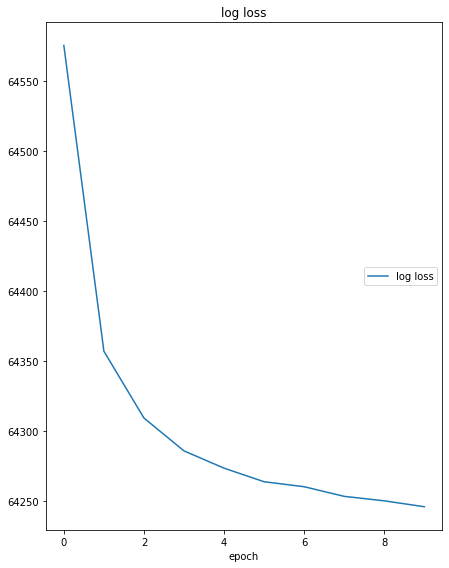

100%|██████████| 10/10 [06:09<00:00, 36.96s/it]

log loss
	log loss         	 (min: 64245.949, max: 64575.375, cur: 64245.949)


In [ ]:
cvae_conv = train_cvae_conv(epochs=epochs)

In [ ]:
# save the model
torch.save(cvae_conv.state_dict(), "./CVAE_CONV.pth")

In [ ]:
lr

0.01

torch.Size([1000])


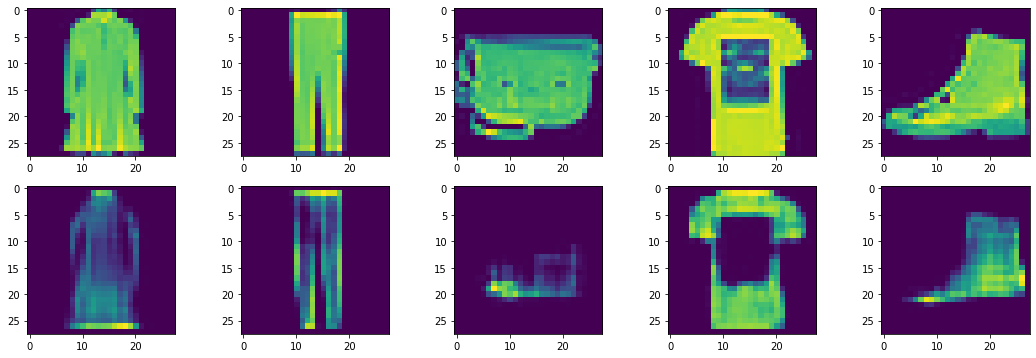

In [ ]:
images, labels = next(iter(test_loader))
print(labels.shape)  # Get the first image from the batch
cvae_conv = cvae_conv.eval()

_, ax = plt.subplots(2, 5, figsize=[18.5, 6])
for n, idx  in enumerate(torch.randint(0,images.shape[0], (5,))):
  recon, _ = cvae_conv(images[idx].unsqueeze(0).cuda(),labels[idx][None])
  ax[0, n].imshow(images[idx].squeeze())
  ax[1, n].imshow(recon.cpu().detach().squeeze())


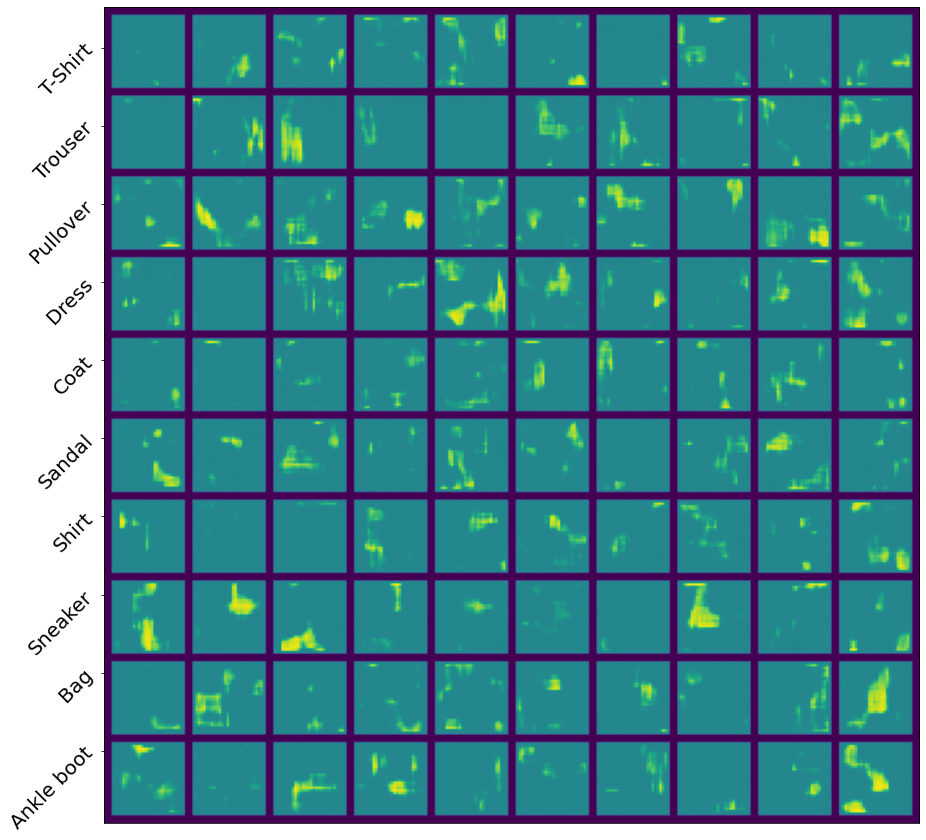

<Figure size 432x288 with 0 Axes>

In [ ]:
def plot_sample(autoencoder, z, l):
    # print(l.shape)
    img = autoencoder.decoder(z, l)#.to('cpu').detach().numpy()#[0,0]
    batch_grid_2 = make_grid(img, nrow=10, padding=3)
    plt.figure(figsize=(15,15))
    plt.imshow(batch_grid_2[0].to('cpu').detach().numpy())
    plt.xticks([])
    plt.yticks(np.arange(15, 300, 30), ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], rotation=45, fontsize=20)
    plt.show()
    plt.savefig("./cvae_conv.jpg")
    # print(z)


z = torch.randn((100,120,4,4)).to(device).float()
l = torch.empty(0)
for li in np.arange(10):
  l = torch.cat((l,torch.full((10,), li)))

plot_sample(cvae_conv, z, l)

References:
https://agustinus.kristia.de/techblog/2016/12/17/conditional-vae/

<br>

---

<br>

## **Q3** - Implement a **conditional GAN** that generates a user-defined class [25 points]

Implement a GANs similar to the one we saw in class but with the following modifications:

- Your new network should generate samples of any class defined by the user, that is, when you run your generator, you have to tell it which class you want it to generate. <br> *During the lectures we created a GAN that would generate samples of any class, we did not have control over which class would be generated. The exercise is to modify the network, training loops, and anything else you consider necessary, so that, once is trained, you can generate images of any particular class specified when you run your generative model.*

- Expand your network to include **at least two** of the following modifications. Choose them based on what you think will result in better network performance (make sure to justify your choices well, argumenting why did you decide to include your particular modifications):
  - Convolutional layers
  - Data augmentation
  - Different activations
  - Different random seed
  - Other network modifications that are well justified. <br> *You have freedom to choose what to do here, but your marks will depend not only on the correct implementation but also on the justification of your choices.*

- Use your trained conditional GAN to **generate and plot 10 new samples of each class** by adding the class label to your random input (in any form you have implemented it).

- You **DO NOT** have to optimise any hyperparameters, but if you had to choose three hyperparameters to optimise:
  - Which ones would you choose and why?
  - Would they be different from your choices in **Q2**?


Generate information of your training process (liveloss plots, or any other data that will help you understand your results and analyse them in the last question **Q4**).

### Modifications:


- Use nn.embedding to increase label ventor length before concatenating. This is because the linear CVAE implemented before shows some misgenerated pictures, like generating 'shirts' with label 'dress', which may be due to I only use the label as one-length vector to concatenate. It is likely to be disregard by a big network. So increasing the length of the label may reduce the risk of the label being ignored, and have less misgenerated pictures.

- Use Leaky_ReLU instead of ReLU. It can decrease the possiblity of having a vanishing gradient. If the gradient is zero, then backpropogation will fail and no intelligent adjustment of the parameters can be made, because the direction of the adjustment is unknown, and its magnitude must be zero. Learning stops.

- Add dropout layer as stable implicit regulariser to prevent overfitting.

- Use data augmentation. Data augmentaion can increase our dataset by generating new samples based on the original dataset without changing the ideal response of the network to them.


#### CGAN with modifications:

In [ ]:
seed = 0
set_seed(seed)
criterion = nn.BCELoss(reduction='sum') 
z_dim = 100
embedding = 10
bs = 64
n_epoch = 200
lr = 0.0002


In [ ]:
# original architecture
class Generator(nn.Module):
    def __init__(self, g_input_dim=(z_dim+embedding), g_output_dim=28*28): # change g_input_dim form 100 to 110 by add the feature of label # change the z-dim to 10
        super().__init__()       
        self.embedding = nn.Embedding(10, 10) # use embedding to represent labels with embedding vectors
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x, l): # x is z_dim
        # print('l=',l)
        # print('l.shape=',l.shape)
        # print('l.device=',l.device)
        l = torch.squeeze(self.embedding(l),dim=1)
        x = torch.cat((x, l), dim=1)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim=(28*28+embedding)):
        super().__init__()
        self.embedding = nn.Embedding(10, 10) # use embedding to represent labels with embedding vectors
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x, l): # x is 28*28
        l = torch.squeeze(self.embedding(l),dim=1)
        x = torch.cat((x, l), dim=1)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        # print('x=',x)
        x = torch.sigmoid(self.fc4(x))
        # print('x=', x)
        return x
    

# build model
G = Generator().to(device)
D = Discriminator().to(device)



#-------------- training -----------------------------------------------------------------#



def D_train(x, l):
    #-------------- Function of the discriminator training -------------------#
    D.train()
    D_optimizer.zero_grad()

    x_real, y_real = x.view(-1, 28*28), torch.ones(x.shape[0], 1)
    x_real, y_real = x_real.to(device), y_real.to(device)
    l = l.to(device)
    # print('y_real',y_real)

    D_output = D(x_real, l)
    # print('D_output=',D_output.T)
    D_real_loss = criterion(D_output, y_real)
    # print('D_real_loss=',D_real_loss)

    z = torch.randn(x.shape[0], z_dim).to(device)
    x_fake, y_fake = G(z, l), torch.zeros(x.shape[0], 1).to(device)

    D_output = D(x_fake, l)
    D_fake_loss = criterion(D_output, y_fake)
    # print('D_fake_loss=',D_fake_loss)

    D_loss = D_real_loss + D_fake_loss
    # print('D_loss=',D_loss)

    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

def G_train(x):
    #-------------- Function of the generator training ---------------------------------#
    G.train()
    G_optimizer.zero_grad()

    bs = x.shape[0]
    z = torch.randn(bs, z_dim).to(device)
    fake_labels = torch.LongTensor(np.random.randint(0, 10, bs)).cuda()
    # print('fake_labels.shape',fake_labels.shape)
    G_output = G(z, fake_labels)

    D_output = D(G_output, fake_labels)

    y = torch.ones(bs, 1).to(device)
    G_loss = criterion(D_output, y)

    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

# optimiser
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=0)

def plot_sample(autoencoder, z, l):
    # print(l.shape)
    img = autoencoder(z, l).view(-1, 1, 28, 28)#.to('cpu').detach().numpy()#[0,0]
    # x.view(-1, 28*28)
    batch_grid_3 = make_grid(img, nrow=10, padding=3)
    plt.figure(figsize=(10,10))
    plt.imshow(batch_grid_3[0].to('cpu').detach().numpy())
    plt.xticks([])
    plt.yticks(np.arange(15, 300, 30), ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], rotation=45, fontsize=15)
    plt.show()
    plt.savefig("./generated_image_2.jpg")
    # print(z)


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


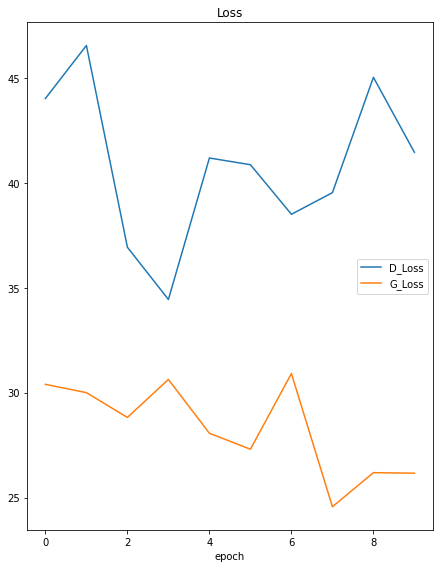

Loss
	D_Loss           	 (min:   34.440, max:   46.541, cur:   41.451)
	G_Loss           	 (min:   24.565, max:   30.910, cur:   26.163)


In [ ]:
#-------------- n_epochs=10 Liveloss training plot --------------------------------------------------#
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in np.arange(10):  
  D_losses, G_losses = [], []
  logs = {}
  for _, (x, l) in enumerate(train_loader):
    # print('x=',x)
    # print('x.mean=',x.mean())
    # print('l=',l)
    l = l[:,None]
    logs['D_Loss'] = D_train(x, l)
    logs['G_Loss'] = G_train(x)

  liveloss.update(logs)
  liveloss.draw()
  # save every 20th epochs
  # if(np.mod(epoch, 20) == 0):
  #   torch.save(G.state_dict(), "./Generator_{:03d}.pth".format(epoch))

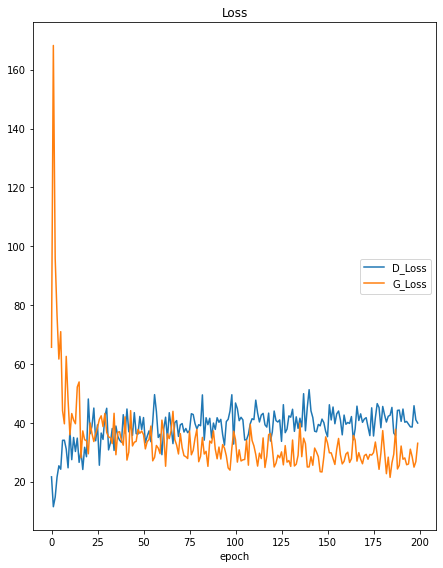

Loss
	D_Loss           	 (min:   11.468, max:   51.251, cur:   39.909)
	G_Loss           	 (min:   21.446, max:  168.223, cur:   33.037)


In [ ]:
#-------------- n_epochs=200 Liveloss training plot --------------------------------------------------#
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in np.arange(n_epoch):  
  D_losses, G_losses = [], []
  logs = {}
  for _, (x, l) in enumerate(train_loader):
    # print('x=',x)
    # print('x.mean=',x.mean())
    # print('l=',l)
    l = l[:,None]
    logs['D_Loss'] = D_train(x, l)
    logs['G_Loss'] = G_train(x)

  liveloss.update(logs)
  liveloss.draw()
  # save every 20th epochs
  # if(np.mod(epoch, 20) == 0):
  #   torch.save(G.state_dict(), "./Generator_{:03d}.pth".format(epoch))

z= torch.Size([100, 100])
l= torch.Size([100])


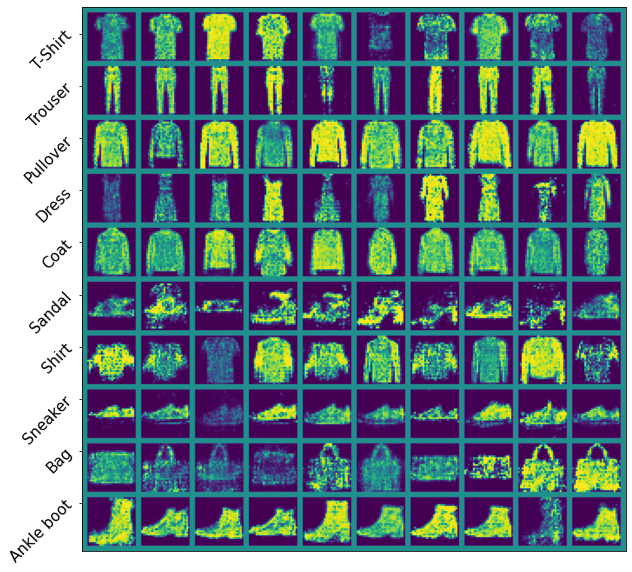

<Figure size 432x288 with 0 Axes>

In [ ]:
z = torch.randn((100,z_dim)).to(device).float()
l = torch.empty(0)
for li in np.arange(10):
  l = np.concatenate((l,np.full((10,), li)))
  l = torch.LongTensor(l)

print('z=',z.shape)
print('l=',l.shape)
l = l[:,None].to(device)
plot_sample(G, z, l)

#### Data Augmentation

In [ ]:
from torch.utils.data import Dataset 
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage

class CustomImageTensorDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        sample = sample.view(1, 28, 28).float()/255.
        if self.transform:
            sample = self.transform(sample)

        return sample, label



train_transform = Compose([
    ToPILImage(),
    RandomRotation(90),
    ToTensor(),
    Normalize(mean=[.5], std=[.5]), 
])

validation_test_transform = Compose([
    Normalize(mean=[.5], std=[.5])
])


train_dataset_1 = CustomImageTensorDataset(mnist_train.data, mnist_train.targets, transform=train_transform)     # create train custom dataset
test_dataset_1 = CustomImageTensorDataset(mnist_test.data, mnist_test.targets, transform=validation_test_transform) # create validation custom dataset
print(train_dataset_1)

train_loader_1 = DataLoader(train_dataset_1, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader_1 = DataLoader(test_dataset_1, batch_size=test_batch_size, shuffle=False, num_workers=0)
batch, label = next(iter(train_loader_1))
print(batch.shape)

In [ ]:
epochs=200
#-------------- n_epochs=200 Liveloss training plot --------------------------------------------------#
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in np.arange(n_epoch):  
  D_losses, G_losses = [], []
  logs = {}
  for _, (x, l) in enumerate(train_loader_1):
    # print('x=',x)
    # print('x.mean=',x.mean())
    # print('l=',l)
    l = l[:,None]
    logs['D_Loss'] = D_train(x, l)
    logs['G_Loss'] = G_train(x)

  liveloss.update(logs)
  liveloss.draw()
  # save every 20th epochs
  # if(np.mod(epoch, 20) == 0):
  #   torch.save(G.state_dict(), "./Generator_{:03d}.pth".format(epoch))

### Hyperparameters:

I will choose to modify epochs, batch size, and the dimension of latent space.

As seen from the loss plot(epochs=10), my model is in the state of underfitting. The Generator and Discreminator lines in the loss plot haven't become stable and still tend to get closer to each other. So, I need to increase the number of epochs (like from 10 to 200, already changed), and increase the dimension of latent space (from 100 to 110). To make the model change faster, I will reduce the batch size (from 64 to 32).

The difference is that learning rate seems right, so I don't need to change it this time.


References: 

https://www.kaggle.com/code/arturlacerda/pytorch-conditional-gan/notebook

https://www.janbasktraining.com/community/qa-testing/leaky-relu-vs-relu-explain-the-difference

<br>

---

<br>

## **Q4** - Analysis and comparison of results [20 points]

Analyse and compare the results you have obtained with the two networks above.

- Use the data you generated training the two networks above to discuss the results you have generated in **Q2** and **Q3**.
- Is there a network that performs better than the other? Why do you think that is?
- What could you do to improve your results on each of the networks you have implemented? ***\[limit your answer to this question to 150 words\]***

**IMPORTANT NOTE**: even if you did not complete **Q2** and **Q3**, make sure to include a discussion with any partial results or other considerations regarding the performance of your implemented methods.

For linear CVAE, 

- Good
 - the loss line goes down and the generative pictures seems ok.


- Bad
 - the loss plot shows that the model is still going down which means it is underfitting, so it needs more training. 
 - And the generated picture shows that although given label, there are some wrongly generated pictures. This indicates that the weights of label hasn't been big enough, so the network may disregard the label. Considering I only cancatenate one label value to the input, it may have too small dimension compared to the input size. 
 - the loss value is also too high. Breaking down the loss, it is mainly because the DKL is too high.
 - only limited amount of features can be represent, so it needs more latent space dimension.

For linear CGAN,
- Good
 - the loss line goes down, and the loss value is small
 - and most of generative pictures look correct according to their labels and complete.

- Bad
  - the loss plot(epochs=10) shows it is underfitting, so it also needs more training.
  - most generateive pictures are correct, while there are still some labels dosen't look good, like scandal, which is more complicated to generate. So maybe need more latent space dimensions.

Compare results of the two linear network, the CGAN performs much better than CVAE. The reason is that
- loss function in VAE is pixel-wise, but it is the BSELoss, which is more 'flexible' and 'intelligent'. 
- It also produces perceptually better results than VAEs' MSE loss. 
- And the latent space dimension used in my CGAN is much greater than the one in CVAE. More latent space may have more features to be represented, so my CGAN is much better than CVAE. 

According to the analysis of the result, here are some improvement advice.

For linear CVAE, 

- more epochs
- reduce learning rate
- fisrt embedding label to longer vectors then concat
- increase latent space dimension
- batch size

For CGAN,
- more epochs
- more latent space dimensions

<br>

---

<br>

## **Q5** - Modify your dataset to create data imbalance and retrain **one** of your conditional models [20 points]

Modify the `FashionMNIST` dataset to eliminate 90% of the images corresponding to one of the classes in the dataset (whichever you want).

Now, **choose one of the two questions below (a or b)**:

- **Q5-a) Retrain your conditional VAE from scratch** with this new dataset, and after training, use it to generate 10 images for the class you have decimated.

- **Q5-b) Retrain your conditional GAN from scratch** with this new dataset, and after training, use it to generate 10 images for the class you have decimated.

- Compare the results of this new images generated with the modified dataset with the original results from questions **Q2** or **Q3** (depending of whether you have chosen **Q5-a** or **Q5-b**). What do you observe? Describe your interpretation of this comparison.

In [ ]:
# making sandal unbalanced
classDict={}
classLabel={}
X_train = torch.empty(0)
y_train = torch.empty(0)
for i in range(10):
    mask = (train_dataset.targets == i)
    if i == 0: # unbalabnce the last label
      classDict[i] = train_dataset.data[mask][:600][:, None,: ,: ]
      classLabel[i] = train_dataset.targets[mask][:600]
    else:
      classDict[i] = train_dataset.data[mask][:, None,: ,: ]
      classLabel[i] = train_dataset.targets[mask]

    X_train = torch.cat((X_train,classDict[i]))
    y_train = torch.cat((y_train,classLabel[i]))

mnist_train_unb = TensorDataset(X_train, y_train.long())
train_loader_unb = DataLoader(mnist_train_unb, batch_size=batch_size, shuffle=True, num_workers=0)


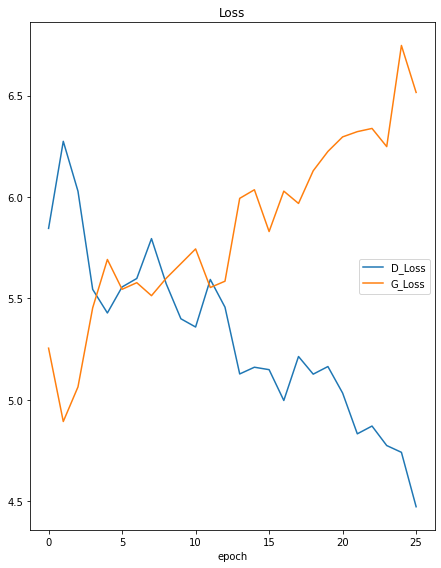

Loss
	D_Loss           	 (min:    4.473, max:    6.275, cur:    4.473)
	G_Loss           	 (min:    4.893, max:    6.747, cur:    6.516)


KeyboardInterrupt: ignored

In [ ]:
seed = 42
set_seed(seed)
criterion = nn.BCELoss(reduction='sum') 
z_dim = 100
embedding = 10
bs = 64
n_epoch = 100 # to run faster use 100 epochs instead
lr = 1e-6

# build model
G = Generator().to(device)
D = Discriminator().to(device)
# optimiser
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

#-------------- n_epochs=200 Liveloss training plot --------------------------------------------------#
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in np.arange(n_epoch):  
  D_losses, G_losses = [], []
  logs = {}
  for _, (x, l) in enumerate(train_loader_unb):
    # print('x=',x)
    # print('x.mean=',x.mean())
    # print('l=',l)
    l = l[:,None]
    logs['D_Loss'] = D_train(x, l)
    logs['G_Loss'] = G_train(x)

  liveloss.update(logs)
  liveloss.draw()
  # save every 20th epochs
  # if(np.mod(epoch, 20) == 0):
  #   torch.save(G.state_dict(), "./Generator_{:03d}.pth".format(epoch))

z= torch.Size([100, 100])
l= torch.Size([100])


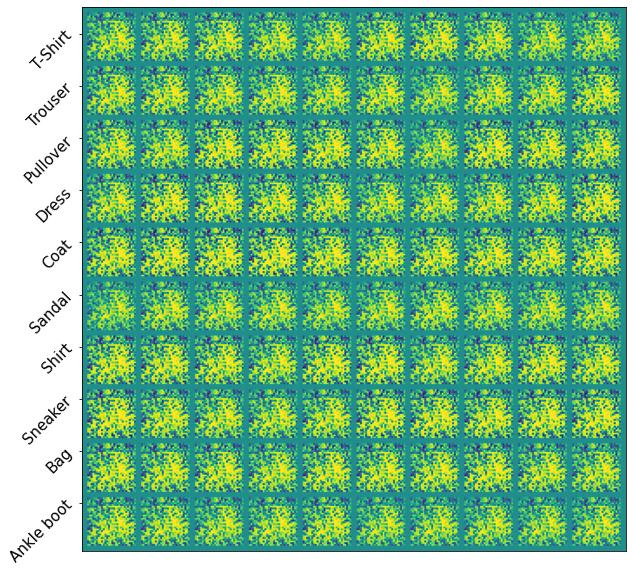

<Figure size 432x288 with 0 Axes>

In [ ]:
z = torch.randn((100,z_dim)).to(device).float()
l = torch.empty(0)
for li in np.arange(10):
  l = np.concatenate((l,np.full((10,), li)))
  l = torch.LongTensor(l)

print('z=',z.shape)
print('l=',l.shape)
l = l[:,None].to(device)
plot_sample_gan(G, z, l)

text block for your answers

text block for your answers